# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: Denoising MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [3]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [4]:
# # import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# # don't need labels!
# data = data[:,1:]

import torchvision
MNIST = torchvision.datasets.MNIST(".", download=True)
data = MNIST.train_data
labels = MNIST.train_labels

data = data.view(data.shape[0], -1).numpy()
labels = labels.numpy()

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

c:\Users\pmiha\anaconda3\envs\MLFlow_env\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\pmiha\anaconda3\envs\MLFlow_env\lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


# Create the DL model

In [14]:
# create a class for the model
def createTheMNISTAE(nEnc = 250, nLat = 50, nDec = 250):

  class aenet(nn.Module):
    def __init__(self, nEnc = 250, nLat = 50, nDec = 250):
      super().__init__()

      ### input layer
      self.input = nn.LazyLinear(nEnc) #nn.LazyLinear(784,250)
      
      ### encoder layer
      self.enc = nn.LazyLinear(nLat)

      ### latent layer
      self.lat = nn.LazyLinear(nDec)

      ### decoder layer
      self.dec = nn.LazyLinear(784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet(nEnc,nLat,nDec)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [6]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


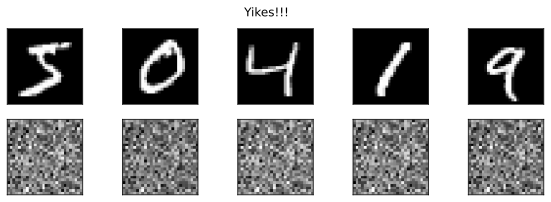

In [7]:
# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Yikes!!!')
plt.show()

# Create a function that trains the model

In [15]:
def function2trainTheModel(nEnc = 250, nLat = 50, nDec = 250):

  # number of epochs
  numepochs = 10000
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE(nEnc, nLat, nDec)

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0068


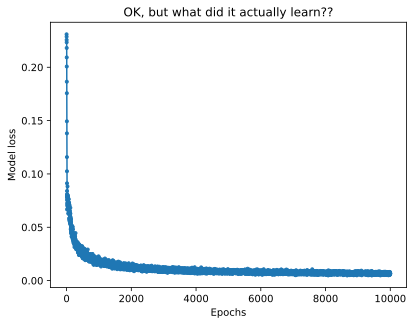

In [16]:
# train the model (90s)
losses,net = function2trainTheModel(nEnc = 250, nLat = 50, nDec = 250)
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn??')
plt.show()

In [24]:
torch.mean(losses[-3:])

tensor(0.0065)

In [25]:
nEncoders =  np.linspace(10,500,2).astype(int)
nBottle = np.linspace(5,100,2).astype(int)

In [27]:
nEncoders =  np.linspace(10,500,2).astype(int)
nBottle = np.linspace(5,100,2).astype(int)

nLosses = np.zeros((len(nEncoders),len(nBottle)))

for idx_Enco,Enco in enumerate(nEncoders):
    for idx_Bott, Bott in enumerate(nBottle):
        print(f'Encoder: {Enco}, Bottle: {Bott}')
        losses,net = function2trainTheModel(nEnc = Enco, nLat = Bott, nDec = Enco)
        print(f'Final loss: {losses[-1]:.4f}')
        nLosses[idx_Enco, idx_Bott] = torch.mean(losses[-3:])
        



Encoder: 10, Bottle: 5
Final loss: 0.0479
Encoder: 10, Bottle: 100
Final loss: 0.0330
Encoder: 500, Bottle: 5
Final loss: 0.0291
Encoder: 500, Bottle: 100
Final loss: 0.0042


In [30]:
from tqdm import tqdm

nEncoders =  np.linspace(10,500,12).astype(int)
nBottle = np.linspace(5,100,8).astype(int)

nLosses = np.zeros((len(nEncoders),len(nBottle)))

for idx_Enco, Enco in enumerate(tqdm(nEncoders, desc="Encoders")):
    for idx_Bott, Bott in enumerate(tqdm(nBottle, desc="Bottlenecks", leave=False)):
        losses, net = function2trainTheModel(nEnc = Enco, nLat = Bott, nDec = Enco)
        nLosses[idx_Enco, idx_Bott] = torch.mean(losses[-3:])


Encoders: 100%|██████████| 12/12 [48:17<00:00, 241.42s/it]


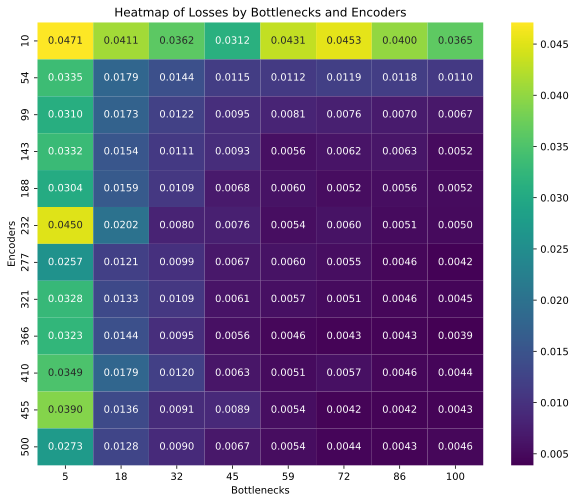

In [31]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(nLosses, xticklabels=nBottle, yticklabels=nEncoders, annot=True, fmt=".4f", cmap="viridis")
plt.xlabel('Bottlenecks')
plt.ylabel('Encoders')
plt.title('Heatmap of Losses by Bottlenecks and Encoders')
plt.show()

Final loss: 0.0052


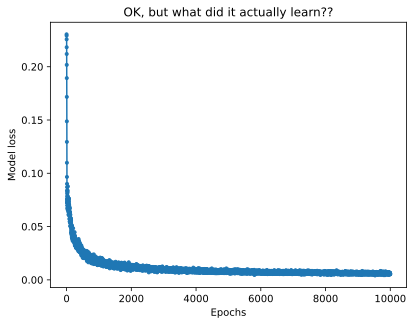

In [9]:
# train the model (90s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('OK, but what did it actually learn??')
plt.show()

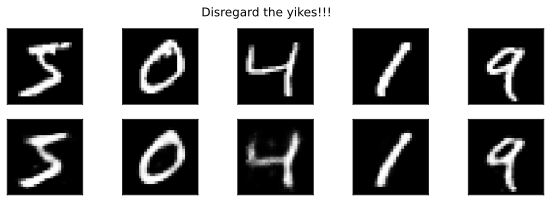

In [10]:
# Repeat the visualization when testing the model
X = dataT[:5,:]
yHat = net(X)


# let's see what the model did!
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.suptitle('Disregard the yikes!!!')
plt.show()

# Add noise to see a use case of an autoencoder

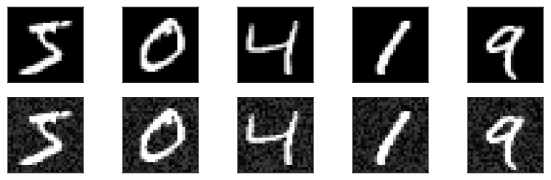

In [17]:
# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  
plt.show()

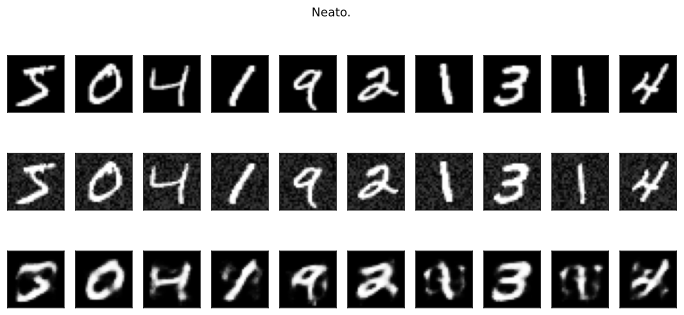

In [18]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.suptitle('Neato.')
plt.show()

# Additional explorations

In [13]:
# 1) Because these are continuous data, mean-squared-error is the correct loss function. But I mentioned in the previous 
#    video that binary cross-entropy loss is *sometimes* used in autoencoders. Does the loss function make a difference
#    for this problem? Why?
# 
# 2) Change the number of units in the latent layer to 10. How does that affect the loss and denoising? Don't turn this 
#    into a full parametric experiment -- that's for the next video!
# 
# 3) The code here picks samples randomly, which means many samples are skipped, and some could be repeated. Change the 
#    code so that the model goes through every item exactly once per epoch. The order should be randomized to avoid 
#    possible order effects. You'll probably want to reduce the number of epochs!
# 
# 4) Is it necessary to normalize the data to a range of [0 1]? What are arguments for normalization, and arguments why
#    it may not be critical (in this problem)?
# 
# 5) The autoencoder did a pretty decent job at denoising the images. How far can you push this? Try adding more noise
#    to the images and re-running the test code (you don't need to retrain the model). Is the autoencoder robust to a
#    a larger amount of noise?
# 